In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
from fbprophet import Prophet
from bs4 import BeautifulSoup

In [102]:
col_titles = ["date", "min", "avg", "max"]
winter_df = pd.DataFrame(columns=col_titles)
summer_df = pd.DataFrame(columns=col_titles)

def getData(df, date):
    """ Takes in a dataframe and the date and inserts the min, avg, and
        max temperatures of that date to the dataframe. """

    url = requests.get("https://www.almanac.com/weather/history/IL/Chicago/" + date)
    content = url.text
    # soup = BeautifulSoup(content, 'html5lib')
    html = pd.read_html(content, header=0)[0]

    html["date"] = date
    data = [html.iloc[0][2], html.iloc[0][1], html.iloc[1][1], html.iloc[2][1]]
    df.loc[len(df)] = data

# Summer range: 1946-06-21 to 2020-09-22
# Winter range: 1945-12-21 to 2020-03-20
years = range(1946,2021)
summer_start = '06-21'
summer_end = '09-22'
winter_start = '12-21'
winter_end = '03-20'
summer_dates = []
winter_dates = []
for y in years:
    ss = str(y) + '-' + summer_start
    se = str(y) + '-' + summer_end
    ws = str(y-1) + '-' + winter_start
    we = str(y) + '-' + winter_end
    summer = pd.date_range(ss, se, freq = 'D')
    for s in summer:
        summer_dates.append(str(s.date()))
    winter = pd.date_range(ws, we, freq = 'D')
    for w in winter:
        winter_dates.append(str(w.date()))

In [98]:
batch = range(0, len(winter_dates), 1000)
for dates in [winter_dates[i : i + 1000] for i in batch]:
    for date in dates:
        getData(winter_df, date)
winter_df.to_csv("winter_data.csv")

In [106]:
batch = range(0, len(summer_dates), 500)

for dates in [summer_dates[i : i + 500] for i in batch]:
    for date in dates:
        getData(summer_df, date)       
summer_df.to_csv("summer_data.csv")


In [78]:
winter_df = pd.read_csv('winter_data.csv', index_col=0)
summer_df = pd.read_csv('summer_data.csv', index_col=0)

In [80]:
# Remove ºF from temperature data
def removeUnit(val):
    ''' Removes the unit from the value. Returns value.'''
    new = str(val)
    new = new[ : new.find(' ')]
    return new

winter_df['min'] = winter_df['min'].apply(removeUnit)
winter_df['avg'] = winter_df['avg'].apply(removeUnit)
winter_df['max'] = winter_df['max'].apply(removeUnit)
summer_df['min'] = summer_df['min'].apply(removeUnit)
summer_df['avg'] = summer_df['avg'].apply(removeUnit)
summer_df['max'] = summer_df['max'].apply(removeUnit)

# Create year column by extracting year from date column
winter_df['date'] = pd.to_datetime(winter_df['date'])
summer_df['date'] = pd.to_datetime(summer_df['date'])
winter_df['year'] = pd.DatetimeIndex(winter_df['date']).year
summer_df['year'] = pd.DatetimeIndex(summer_df['date']).year

winter_df['min'] = pd.to_numeric(winter_df['min'])
winter_df['avg'] = pd.to_numeric(winter_df['avg'])
winter_df['max'] = pd.to_numeric(winter_df['max'])
summer_df['min'] = pd.to_numeric(summer_df['min'])
summer_df['avg'] = pd.to_numeric(summer_df['avg'])
summer_df['max'] = pd.to_numeric(summer_df['max'])

winter_min_summary_df = winter_df.groupby(['year'])['min'].describe()
winter_min_summary_df.to_csv('winter_min_summary')
winter_avg_summary_df = winter_df.groupby(['year'])['avg'].describe()
winter_avg_summary_df.to_csv('winter_avg_summary')
winter_max_summary_df = winter_df.groupby(['year'])['max'].describe()
winter_max_summary_df.to_csv('winter_max_summary')
summer_min_summary_df = summer_df.groupby(['year'])['min'].describe()
summer_min_summary_df.to_csv('summer_min_summary')
summer_avg_summary_df = summer_df.groupby(['year'])['avg'].describe()
summer_avg_summary_df.to_csv('summer_avg_summary')
summer_max_summary_df = summer_df.groupby(['year'])['max'].describe()
summer_max_summary_df.to_csv('summer_max_summary')

In [5]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox
from pmdarima import auto_arima
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import pacf
import warnings
warnings.filterwarnings('ignore')

In [6]:
# Taken from https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.adfuller.html
def ad_test(dataset):
     dftest = adfuller(dataset, autolag = 'AIC')
     print("1. ADF : ",dftest[0])
     print("2. P-Value : ", dftest[1])
     print("3. Num Of Lags : ", dftest[2])
     print("4. Num Of Observations Used For ADF Regression:", dftest[3])
     print("5. Critical Values :")
     for key, val in dftest[4].items():
         print("\t",key, ": ", val)

In [33]:
winter_avg_df = winter_df[['date', 'avg']]
winter_avg_df.set_index('date', inplace = True)
winter_avg_df

,avg
date,
1945-12-21,6.0
1945-12-22,7.4
1945-12-23,19.2
1945-12-24,23.6
1945-12-25,31.8
...,...
2020-03-16,35.6
2020-03-17,38.9
2020-03-18,37.9


In [8]:
ad_test(winter_avg_df)

1. ADF :  -19.018783656883496
2. P-Value :  0.0
3. Num Of Lags :  7
4. Num Of Observations Used For ADF Regression: 6755
5. Critical Values :
	 1% :  -3.4313184362272238
	 5% :  -2.8619679685673516
	 10% :  -2.5669978039733707


p-value < 0.05; therefore, data is stationary. Proceed with using ARIMA

In [29]:
# Finds the ideal p,d,q parameters
# Set d = 0 because data is stationary
stepwise_fit = auto_arima(winter_avg_df, trace=True, suppress_warnings=True, d=0)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=45749.420, Time=3.56 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=51972.050, Time=0.10 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=46079.502, Time=0.25 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=47580.399, Time=0.54 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=65813.867, Time=0.07 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=45782.313, Time=1.38 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=45828.769, Time=1.67 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=45751.419, Time=5.10 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=45751.448, Time=5.31 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=45869.855, Time=0.92 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=45753.960, Time=2.15 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=45772.095, Time=2.99 sec
 ARIMA(3,0,3)(0,0,0)[0] intercept   : AIC=45751.556, Time=5.43 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=2.05 sec

Best model:  ARIMA(2,0,2

In [9]:
best_model = ARIMA(winter_df['avg'], order=(2,0,2)).fit()
print(best_model.summary())

                               SARIMAX Results                                
Dep. Variable:                    avg   No. Observations:                 6763
Model:                 ARIMA(2, 0, 2)   Log Likelihood              -22868.710
Date:                Sun, 24 Apr 2022   AIC                          45749.420
Time:                        22:17:28   BIC                          45790.335
Sample:                             0   HQIC                         45763.543
                               - 6763                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         29.2966      0.472     62.100      0.000      28.372      30.221
ar.L1          1.2469      0.052     24.081      0.000       1.145       1.348
ar.L2         -0.3161      0.040     -7.912      0.0

In [10]:
# Ljung-Box test
acorr_ljungbox(best_model.resid, lags=[10], return_df=True)

,lb_stat,lb_pvalue
10,2.109686,0.995428


p-value is > 0.05, so the residuals are not correlated.

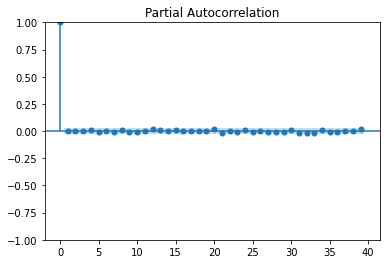

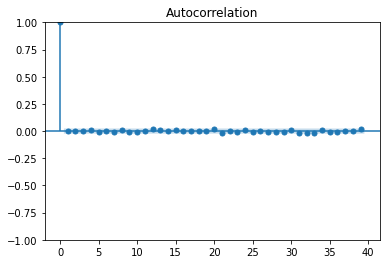

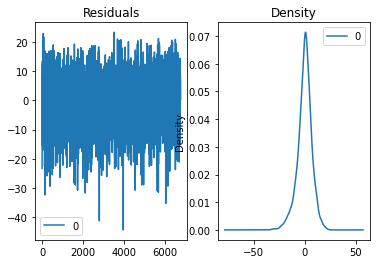

In [11]:
plot_pacf(best_model.resid)
plot_acf(best_model.resid)

residuals = pd.DataFrame(best_model.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

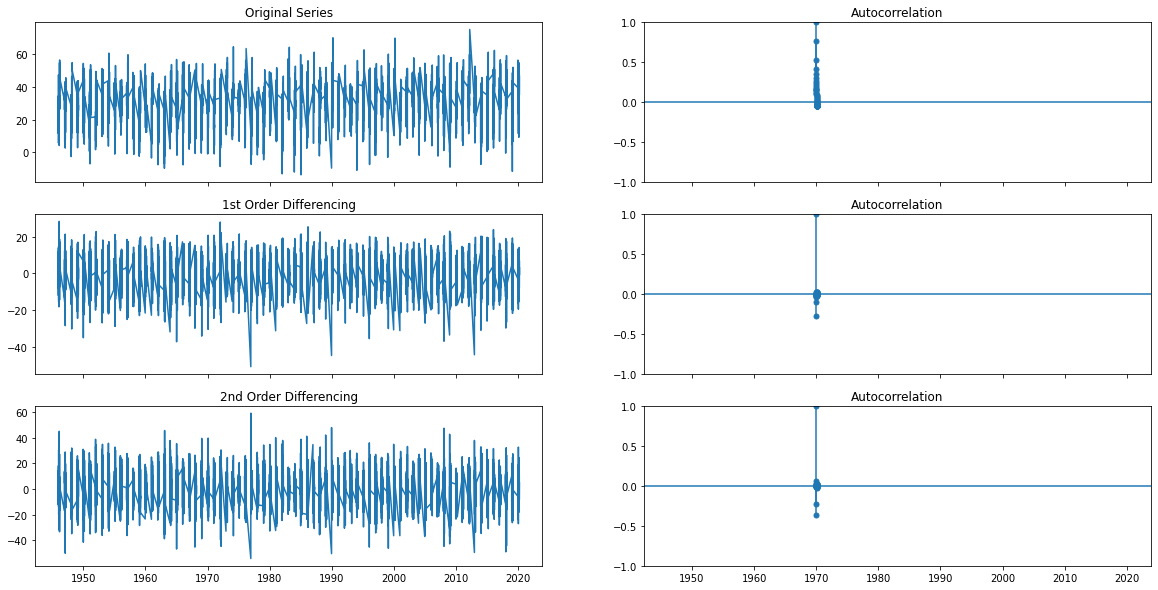

In [74]:
fig, axes = plt.subplots(3, 2, sharex=True, figsize=(20,10))
axes[0, 0].plot(winter_avg_df.avg); axes[0, 0].set_title('Original Series')
plot_acf(winter_avg_df.avg, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(winter_avg_df.avg.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(winter_avg_df.avg.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(winter_avg_df.avg.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(winter_avg_df.avg.diff().diff().dropna(), ax=axes[2, 1])

# use the original series since differencing causes autocorrelation to dip into negatives fairly quickly, which indicates overdifferencing
plt.show()

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -156.679
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       10629.4    0.00327104       298.612           1           1      116   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       10635.2    0.00546017       399.486           1           1      232   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299         10638   0.000203618       93.8937           1           1      349   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     345       10638.1   5.10599e-05       74.8728   6.752e-07       0.001      451  LS failed, Hessian reset 
     370       10638.1   7.44144e-07       74.7143           1           1      480   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -219.607
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       8696.01    0.00364032       79.2167           1           1      113   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       8701.24   0.000554931       90.6846       1.938      0.1938      229   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     214       8701.38    0.00040034       135.154   6.931e-06       0.001      278  LS failed, Hessian reset 
     258       8701.68   0.000618506       71.7545   7.743e-06       0.001      365  LS failed, Hessian reset 
     299       8701.75   0.000246323       71.2766           1           1      415   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     325       8701.76   6.01403e-05       79.4574   9.041e-07       0.001      491  LS failed, Hessian rese

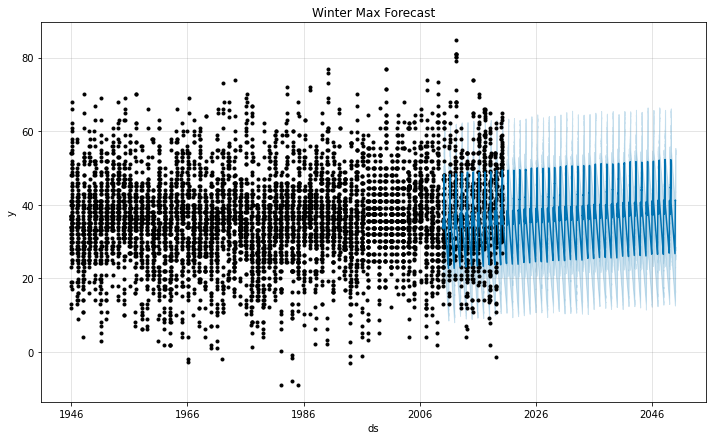

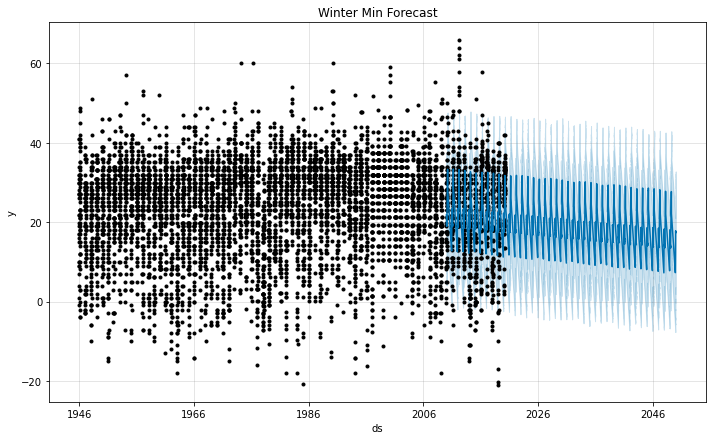

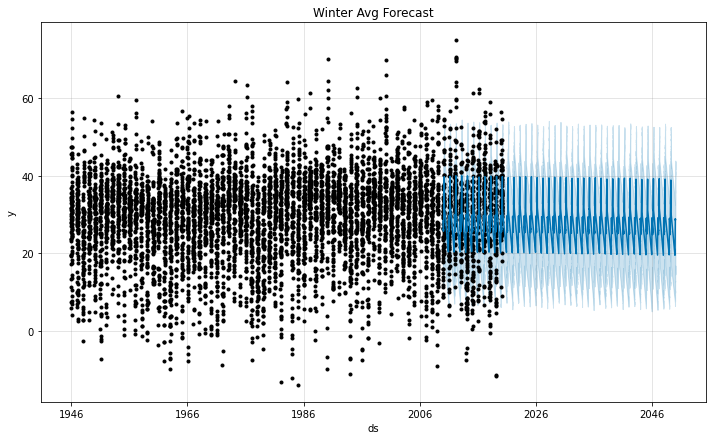

<Figure size 1440x720 with 0 Axes>

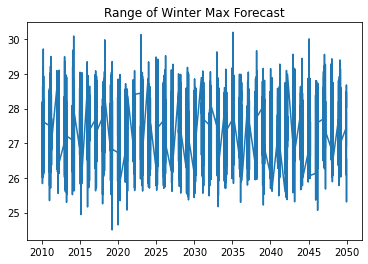

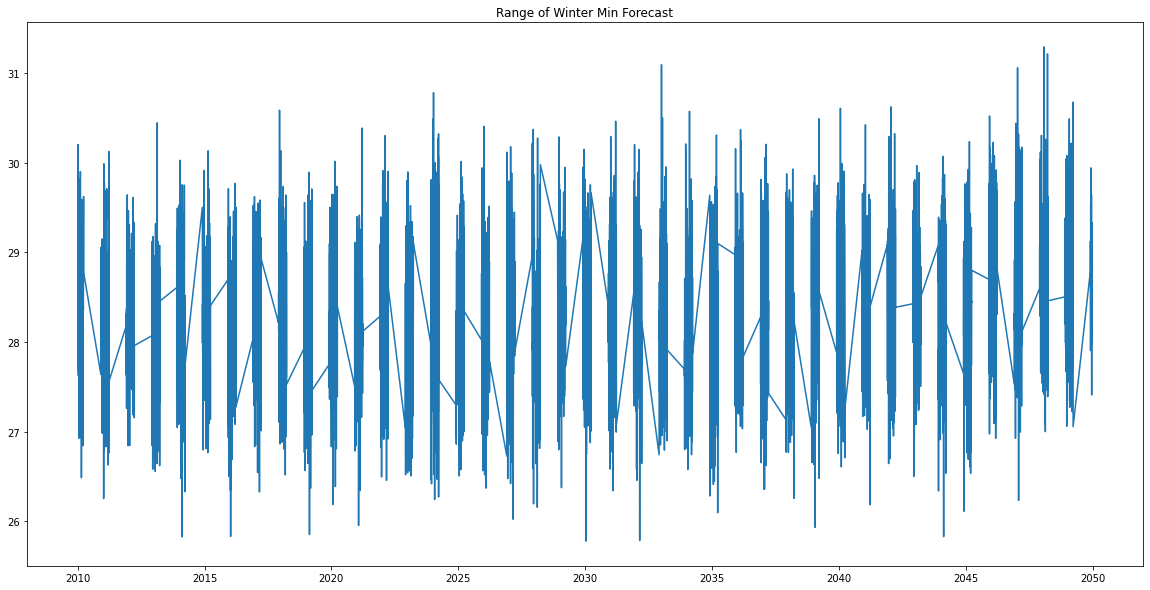

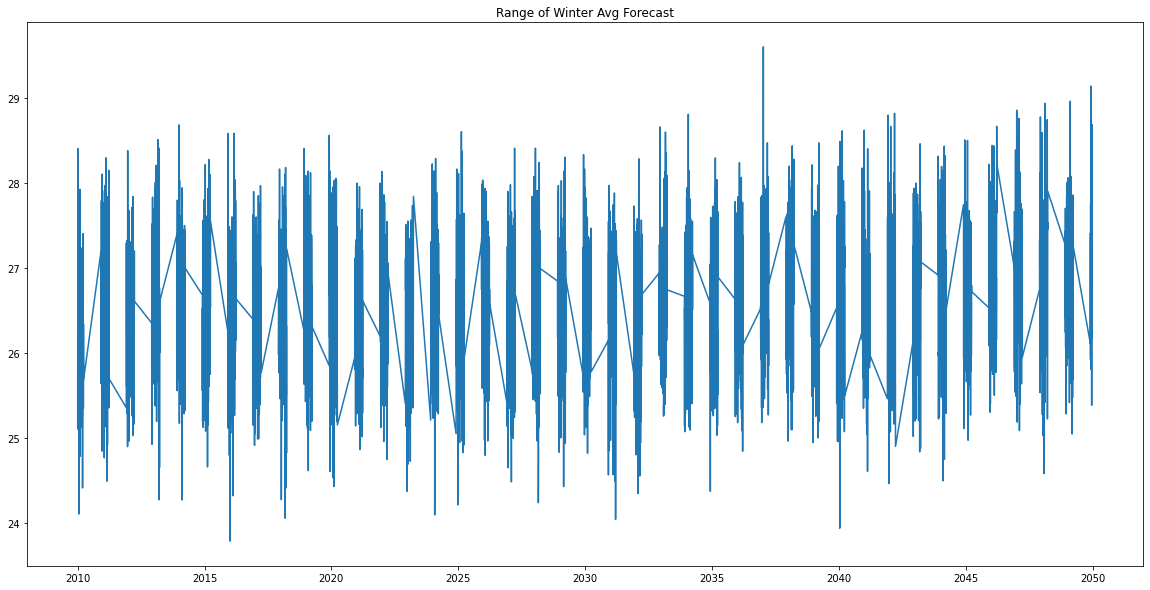

<Figure size 1440x720 with 0 Axes>

In [101]:
# winter forecasts

# define the model
winter_max_model = Prophet()
winter_min_model = Prophet()
winter_avg_model = Prophet()

# fit the model
max_df = winter_df[['date', 'max']]
max_df.set_index('date', inplace = True)
max_df['ds'] = max_df.index
max_df.columns = ['y', 'ds']
winter_max_model.fit(max_df);

min_df = winter_df[['date', 'min']]
min_df.set_index('date', inplace = True)
min_df['ds'] = min_df.index
min_df.columns = ['y', 'ds']
winter_min_model.fit(min_df);

avg_df = winter_df[['date', 'avg']]
avg_df.set_index('date', inplace = True)
avg_df['ds'] = avg_df.index
avg_df.columns = ['y', 'ds']
winter_avg_model.fit(avg_df);

# define the period for which we want a prediction -- winter months 2010-2050
def prediction_dates(months):
    future = list()
    for j in range(2010, 2050):
        for i in months:
            mon = str(i)
            if len(mon) == 1:
                mon = "0{num}".format(num = i)
            for d in range(1, 29):
                day = str(d)
                if len(day) == 1:
                    day = "0{num}".format(num = d)
                date = "{year}-{month}-{dayS}".format(year = j, month = mon, dayS = day)
                future.append([date])
    return future

winter_months = [12, 1, 2, 3]
max_future = prediction_dates(winter_months);
min_future = prediction_dates(winter_months);
avg_future = prediction_dates(winter_months);

max_future = pd.DataFrame(max_future);
min_future = pd.DataFrame(min_future);
avg_future = pd.DataFrame(avg_future);

max_future.columns = ['ds']
min_future.columns = ['ds']
avg_future.columns = ['ds']

max_future['ds']= pd.to_datetime(max_future['ds'], format='%Y-%m-%d')
min_future['ds']= pd.to_datetime(min_future['ds'], format='%Y-%m-%d')
avg_future['ds']= pd.to_datetime(avg_future['ds'], format='%Y-%m-%d')

# use the model to make a forecast
max_forecast = winter_max_model.predict(max_future);
min_forecast = winter_min_model.predict(min_future);
avg_forecast = winter_avg_model.predict(avg_future);

# plot forecast

winter_max_model.plot(max_forecast)
plt.title("Winter Max Forecast")
winter_min_model.plot(min_forecast)
plt.title("Winter Min Forecast")
winter_avg_model.plot(avg_forecast)
plt.title("Winter Avg Forecast")
plt.show()

# plot difference between yhat_upper and yhat_lower
plt.plot(max_forecast['ds'], max_forecast['yhat_upper'] - max_forecast['yhat_lower'])
plt.title("Range of Winter Max Forecast")
plt.figure(figsize=(20,10))

plt.plot(min_forecast['ds'], min_forecast['yhat_upper'] - min_forecast['yhat_lower'])
plt.title("Range of Winter Min Forecast")
plt.figure(figsize=(20,10))

plt.plot(avg_forecast['ds'], avg_forecast['yhat_upper'] - avg_forecast['yhat_lower'])
plt.title("Range of Winter Avg Forecast")
plt.figure(figsize=(20,10))

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -49.6802
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       15570.8    0.00117215        617.61      0.4733      0.4733      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       15576.5   0.000345034       141.856           1           1      227   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       15577.9   0.000171927       63.5149      0.2294           1      347   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     333       15578.2   0.000265162       379.811   1.577e-06       0.001      430  LS failed, Hessian reset 
     399       15578.6   0.000206375       64.2461      0.6701      0.6701      504   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     409       15578.7   0.000121958    

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -115.413
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       15616.9     0.0106567       1714.12           1           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       15623.7    0.00288283       311.484           1           1      229   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299         15626     0.0011372       613.961      0.7662      0.7662      335   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     382       15627.2   5.66405e-05       184.339   2.388e-07       0.001      487  LS failed, Hessian reset 
     399       15627.4     0.0012411       169.602           1           1      506   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       15627.9   0.000156373    

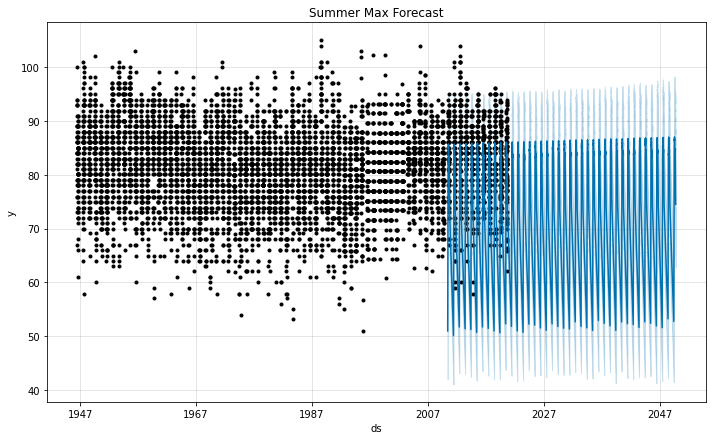

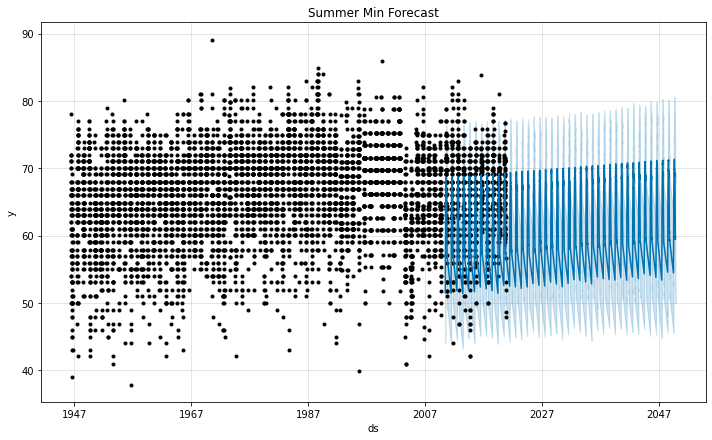

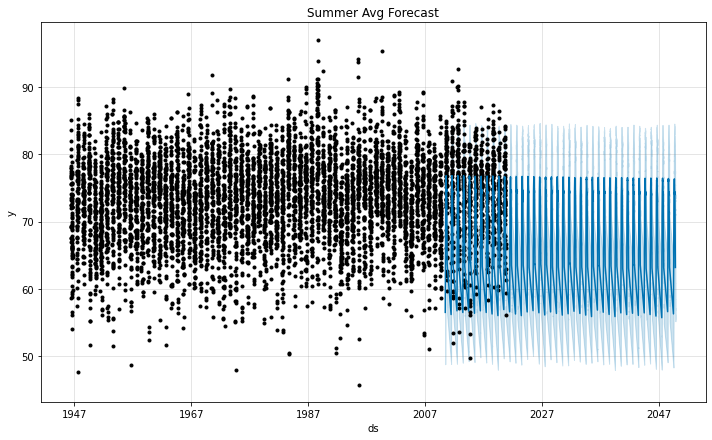

<Figure size 1440x720 with 0 Axes>

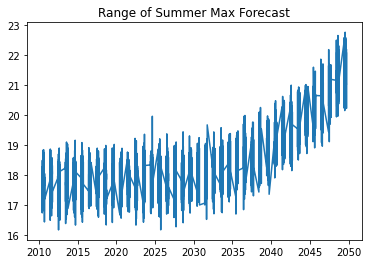

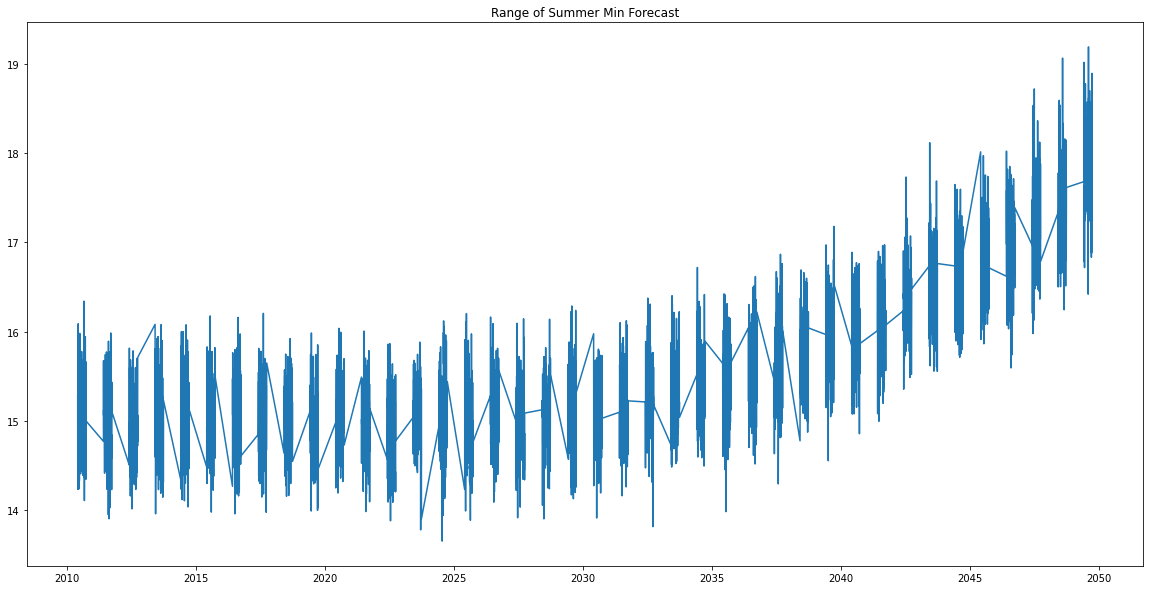

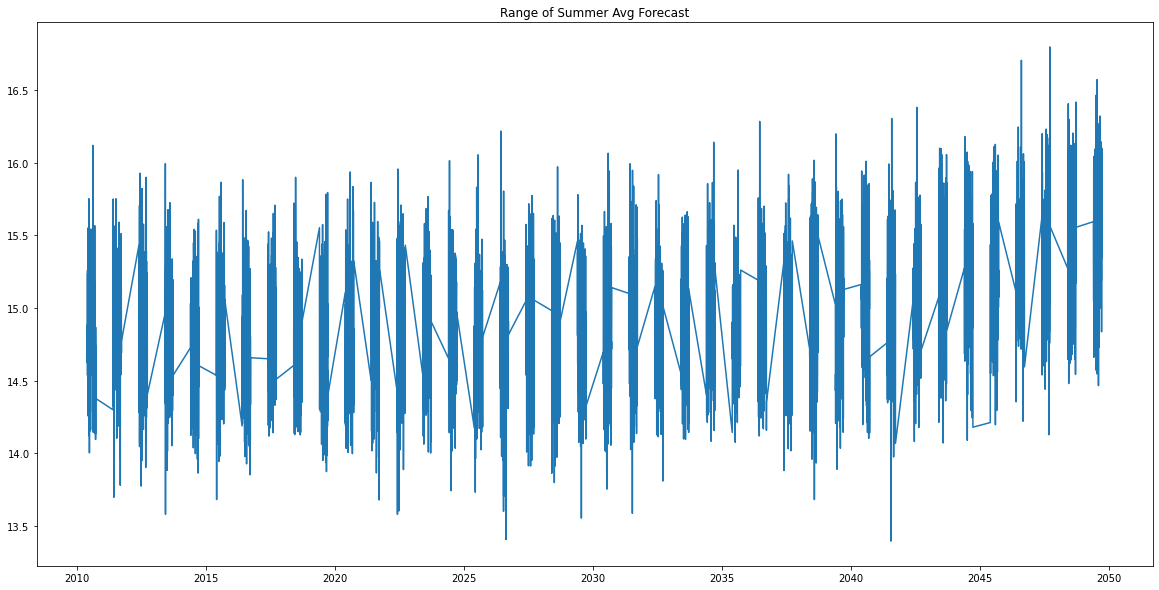

<Figure size 1440x720 with 0 Axes>

In [102]:
# summer forecasts

# define the model
summer_max_model = Prophet()
summer_min_model = Prophet()
summer_avg_model = Prophet()

# fit the model
summer_max_df = summer_df[['date', 'max']]
summer_max_df.set_index('date', inplace = True)
summer_max_df['ds'] = summer_max_df.index
summer_max_df.columns = ['y', 'ds']
summer_max_model.fit(summer_max_df)

summer_min_df = summer_df[['date', 'min']]
summer_min_df.set_index('date', inplace = True)
summer_min_df['ds'] = summer_min_df.index
summer_min_df.columns = ['y', 'ds']
summer_min_model.fit(summer_min_df)

summer_avg_df = summer_df[['date', 'avg']]
summer_avg_df.set_index('date', inplace = True)
summer_avg_df['ds'] = summer_avg_df.index
summer_avg_df.columns = ['y', 'ds']
summer_avg_model.fit(summer_avg_df)

summer_months = [6, 7, 8, 9]
summer_max_future = prediction_dates(summer_months)
summer_min_future = prediction_dates(summer_months)
summer_avg_future = prediction_dates(summer_months)

summer_max_future = pd.DataFrame(summer_max_future)
summer_min_future = pd.DataFrame(summer_min_future)
summer_avg_future = pd.DataFrame(summer_avg_future)

summer_max_future.columns = ['ds']
summer_min_future.columns = ['ds']
summer_avg_future.columns = ['ds']

summer_max_future['ds']= pd.to_datetime(summer_max_future['ds'], format='%Y-%m-%d')
summer_min_future['ds']= pd.to_datetime(summer_min_future['ds'], format='%Y-%m-%d')
summer_avg_future['ds']= pd.to_datetime(summer_avg_future['ds'], format='%Y-%m-%d')

# use the model to make a forecast
summer_max_forecast = summer_max_model.predict(summer_max_future)
summer_min_forecast = summer_min_model.predict(summer_min_future)
summer_avg_forecast = summer_avg_model.predict(summer_avg_future)

# plot forecast
summer_max_model.plot(summer_max_forecast)
plt.title("Summer Max Forecast")
summer_min_model.plot(summer_min_forecast)
plt.title("Summer Min Forecast")
summer_avg_model.plot(summer_avg_forecast)
plt.title("Summer Avg Forecast")
plt.show()

# plot difference between yhat_upper and yhat_lower
plt.plot(summer_max_forecast['ds'], summer_max_forecast['yhat_upper'] - summer_max_forecast['yhat_lower'])
plt.title("Range of Summer Max Forecast")
plt.figure(figsize=(20,10))

plt.plot(summer_min_forecast['ds'], summer_min_forecast['yhat_upper'] - summer_min_forecast['yhat_lower'])
plt.title("Range of Summer Min Forecast")
plt.figure(figsize=(20,10))

plt.plot(summer_avg_forecast['ds'], summer_avg_forecast['yhat_upper'] - summer_avg_forecast['yhat_lower'])
plt.title("Range of Summer Avg Forecast")
plt.figure(figsize=(20,10))